In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.util
import iris
import iris.analysis
import iris.coord_categorisation
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

In [2]:
from aeolus.coord import add_cyclic_point_to_cube

In [3]:
from commons import EXPERIMENTS, LAYERS, SEASONS
from mypaths import path_to_ukca  # path_to_figs
from plot_func import use_draft_style
from proc_func import GASES

In [4]:
warnings.filterwarnings("ignore", module="iris")
# use_draft_style()

In [5]:
# Choose experiments
base_exp = "BASE"
sens_exp = "FIRE"
# Choose layer
layer = "boundary"  # boundary or free troposphere

In [6]:
base_cl = iris.cube.CubeList()
sens_cl = iris.cube.CubeList()
for igas, gasdict in GASES.items():
    if gasdict["noy"]:
        # Load NOy species data and convert it to ppb
        base_cb = (
            iris.load_cube(
                str(path_to_ukca / EXPERIMENTS[base_exp] / f"{EXPERIMENTS[base_exp]}_{igas}.nc"),
                f"{igas}",
            )
            * GASES[igas]["mmr_to_vmr"]
            * 1e9
        )
        sens_cb = (
            iris.load_cube(
                str(path_to_ukca / EXPERIMENTS[sens_exp] / f"{EXPERIMENTS[sens_exp]}_{igas}.nc"),
                f"{igas}",
            )
            * GASES[igas]["mmr_to_vmr"]
            * 1e9
        )
        base_cb.rename(igas)
        sens_cb.rename(igas)

        # Remove the first 2 years of data as a spin up
        base_cb_trimmed = base_cb[24::, ...]
        sens_cb_trimmed = sens_cb[24::, ...]

        base_cl.append(base_cb_trimmed)
        sens_cl.append(sens_cb_trimmed)

In [7]:
# Calculate NOy
base_noy = sum(base_cl)
sens_noy = sum(sens_cl)
base_noy.rename("noy")
sens_noy.rename("noy")

# Add additional time coordinates
iris.coord_categorisation.add_season(base_noy, "time", name="season")
iris.coord_categorisation.add_season(sens_noy, "time", name="season")
iris.coord_categorisation.add_season_year(base_noy, "time", name="year")
iris.coord_categorisation.add_season_year(sens_noy, "time", name="year")

In [8]:
# Calculate RONO2 sum
base_rono2 = sum(base_cl.extract(["meono2", "etono2", "nprono2", "iprono2"]))
sens_rono2 = sum(sens_cl.extract(["meono2", "etono2", "nprono2", "iprono2"]))
base_rono2.rename("rono2")
sens_rono2.rename("rono2")

# Add additional time coordinates
iris.coord_categorisation.add_season(base_rono2, "time", name="season")
iris.coord_categorisation.add_season(sens_rono2, "time", name="season")
iris.coord_categorisation.add_season_year(base_rono2, "time", name="year")
iris.coord_categorisation.add_season_year(sens_rono2, "time", name="year")

# Note: RONO2 concentrations are zero in the BASE experiment

In [9]:
def calc_seasonal_mean_in_layer(cube, season, layer):
    """Calculate seasonal mean in a specified layer and add a cyclic longitude."""
    SEASON = iris.Constraint(season=season)
    cb = cube.extract(SEASON & layer).collapsed(["season", "level_height"], iris.analysis.MEAN)
    cyclic_cb = add_cyclic_point_to_cube(cb)
    return cyclic_cb

In [10]:
base_noy_by_ssn = iris.cube.CubeList()
sens_noy_by_ssn = iris.cube.CubeList()
base_rono2_by_ssn = iris.cube.CubeList()
sens_rono2_by_ssn = iris.cube.CubeList()
for ssn in SEASONS:
    base_noy_by_ssn.append(calc_seasonal_mean_in_layer(base_noy, ssn, LAYERS[layer]))
    sens_noy_by_ssn.append(calc_seasonal_mean_in_layer(sens_noy, ssn, LAYERS[layer]))
    base_rono2_by_ssn.append(calc_seasonal_mean_in_layer(base_rono2, ssn, LAYERS[layer]))
    sens_rono2_by_ssn.append(calc_seasonal_mean_in_layer(sens_rono2, ssn, LAYERS[layer]))

In [11]:
# Horizontal grid
lats = base_cb.coord("latitude").points
lons = base_noy_by_ssn[0].coord("longitude").points

In [12]:
base_rono2_pct_of_noy = iris.cube.CubeList()
for icb, jcb in zip(base_noy_by_ssn, base_rono2_by_ssn):
    base_rono2_pct_of_noy.append(jcb * 100 / icb)

sens_rono2_pct_of_noy = iris.cube.CubeList()
for icb, jcb in zip(sens_noy_by_ssn, sens_rono2_by_ssn):
    sens_rono2_pct_of_noy.append(jcb * 100 / icb)

In [13]:
def plt_ssn_means(cubelist, lons, lats, exp):
    from commons import SEASONS

    map_kw = dict(transform=ccrs.PlateCarree(), levels=np.arange(0, 110, 10),)

    fig, axes = plt.subplots(
        nrows=4,
        ncols=1,
        figsize=(6, 12),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0), facecolor="w"),
    )
    for cube, ttl, ax in zip(cubelist, SEASONS, axes.flatten()):
        p0 = ax.contourf(lons, lats, cube.data, **map_kw)
        ax.coastlines(color="k")  # , linewidth=0.25)
        ax.set_title(ttl.upper(), loc="left")
    axes[0].set_title(exp)

    cax = fig.add_axes([0.39, 0.1, 0.23, 0.01])
    fig.colorbar(p0, cax=cax, orientation="horizontal", label="$RONO_2$ contribution to $NO_y$, %")

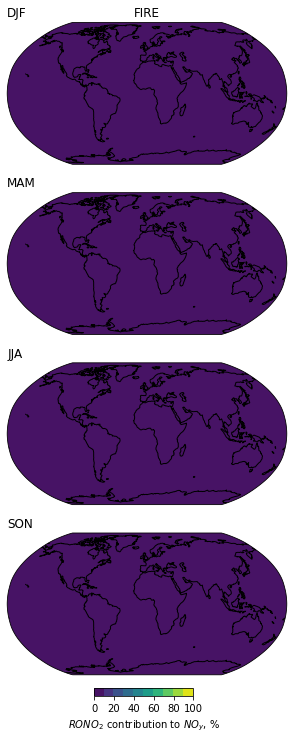

In [14]:
plt_ssn_means(sens_rono2_pct_of_noy, lons, lats, sens_exp)